In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import scipy
import time
import gc
from sys import getsizeof
from scipy.signal import hilbert, hann, convolve
from scipy.ndimage.filters import convolve1d
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook

In [532]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from xgboost import XGBClassifier
from sklearn.svm import NuSVR, SVR
# from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'xgboost'

In [3]:
# train = pd.read_csv("../input/train.csv", dtype={'acoustic_data': np.int16})
train = pd.read_pickle('../input/train.pkl')

In [4]:
train.columns = ['signal','ttq']

In [6]:
train['ttq'] = train.ttq.astype(np.float16)

In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
signal    int16
ttq       float16
dtypes: float16(1), int16(1)
memory usage: 2.3 GB


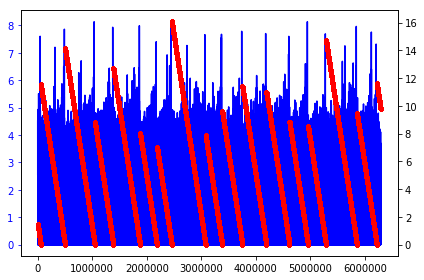

In [8]:
fig, ax1 = plt.subplots()
sig = np.abs(train.signal.values[::100])+1
sig=np.log(sig)
ax1.plot(sig, 'b-')
# Make the y-axis label, ticks and tick labels match the line color.
# ax1.set_yscale('log')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(train.ttq.values[::100], 'r.')

fig.tight_layout()
plt.show()

In [9]:
train.shape

(629145480, 2)

In [10]:
# np.save("../input/x_mat.npy", x_mat)
# np.save("../input/y_train.npy", y_train)
# np.save("../input/y_val.npy", y_val)

In [11]:
gc.collect()

22

In [12]:
n_samples=20000

In [13]:
x_mat = np.load("../input/x_mat.npy")
y_train = np.load("../input/y_train.npy")
y_val = np.load("../input/y_val.npy")

In [49]:
train_len = train.shape[0]

In [27]:
diffs = train.ttq[1:].reset_index(drop=True)-train.ttq[:-1].reset_index(drop=True)

In [60]:
separators = np.array(diffs[diffs>.10].index)+1

In [61]:
separators = np.append(np.array([0]),separators)
separators = np.append(separators, np.array(train_len))

In [62]:
separators

array([        0,   5656574,  50085878, 104677356, 138772453, 187641820,
       218652630, 245829585, 307838917, 338276287, 375377848, 419368880,
       461811623, 495800225, 528777115, 585568144, 621985673, 629145480],
      dtype=int64)

In [63]:
len(separators)

18

In [70]:
n_samples = 17000

In [88]:
ttq_mat = train.ttq.values

In [89]:
sig_mat = train.signal.values

In [75]:
sig_mat.shape[0]/150000

4194.3032

In [86]:
start

585903.0

In [96]:
ttq_mat[separators[i]] * (np.zeros(1000)+1)

array([1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875, 1.46875,
       1.46875, 1.46

In [140]:
rng = np.random.RandomState(7)
samples_per = 1000

train_starts = np.empty([0])
x_mat = np.empty([17*samples_per, 150000])
y_mat = np.empty([17*samples_per, 2])


for i in range(len(separators)-1):
    print(separators[i])
    train_starts=np.append(train_starts,rng.randint(separators[i],separators[i+1]-150000, samples_per))
    y_mat[i*samples_per:(i+1)*samples_per, 1] = ttq_mat[separators[i]]

for i, start in enumerate(train_starts.astype(np.int32)):
    if i%1000 == 0:
        print(i)
    x_mat[i,:] = sig_mat[start:start+150000]
    y_mat[i,0] = ttq_mat[start+150000]
    

0
5656574
50085878
104677356
138772453
187641820
218652630
245829585
307838917
338276287
375377848
419368880
461811623
495800225
528777115
585568144
621985673
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000


In [141]:
y_mat

array([[ 1.27832031,  1.46875   ],
       [ 0.56445312,  1.46875   ],
       [ 0.73730469,  1.46875   ],
       ...,
       [11.171875  , 11.6171875 ],
       [10.328125  , 11.6171875 ],
       [ 9.9765625 , 11.6171875 ]])

In [142]:
x_mat.shape

(17000, 150000)

In [143]:
segments = samples_per * 17

In [144]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train['signal'].mean()
total_std = train['signal'].std()
total_max = train['signal'].max()
total_min = train['signal'].min()
total_sum = train['signal'].sum()
total_abs_sum = np.abs(train['signal']).sum()

In [145]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [146]:
# Incorporating additional features from https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples.
def create_features(seg_id, seg, X):
    xc = pd.Series(seg['signal'].values)
    zc = np.fft.fft(xc)
    
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    
    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    for i in range(20):
        x.loc[seg_id, 'RealFFT' + str(i*1000)] = 
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [148]:
for seg_id in tqdm_notebook(range(segments)):
#     seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    seg = pd.DataFrame({'signal': x_mat[seg_id, :]})
    create_features(seg_id, seg, train_X)

In [149]:
xt_mat = train_X.values

In [151]:
# np.save("../input/xt_mat.npy", xt_mat)

In [153]:
xt_mat.shape

(17000, 154)

In [175]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [177]:
xt_mat = scaled_train_X.values

In [225]:
y_mat

array([[ 1.27832031,  1.46875   ],
       [ 0.56445312,  1.46875   ],
       [ 0.73730469,  1.46875   ],
       ...,
       [11.171875  , 11.6171875 ],
       [10.328125  , 11.6171875 ],
       [ 9.9765625 , 11.6171875 ]])

In [228]:
y_mat.shape

(17000, 2)

In [231]:
add = np.array(y_mat[:,0]/y_mat[:,1])

In [234]:
y_mat = np.append(y_mat, add.reshape([add.shape[0],1]), 1)

In [501]:
x_train, x_test, y_train, y_test = train_test_split(xt_mat, y_mat, test_size=0.5, random_state=42)

In [502]:
x_train.shape

(8500, 154)

In [503]:
y_train.shape

(8500, 3)

In [504]:
y_train[:,0].shape

(8500,)

In [505]:
y_train_ttq = y_train[:,0] 
y_train_max = y_train[:,1]
y_train_pct = y_train[:,2]

In [506]:
y_train_ttq.shape

(8500,)

In [507]:
y_test_ttq = y_test[:,0]
y_test_max = y_test[:,1]
y_test_pct = y_test[:,2]

In [523]:
import tensorflow
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, Input, Bidirectional

inputs = Input(shape=x_train.shape[1:])
X = Dense(8)(inputs)
X = Dropout(0.25)(X)
# X = Dense(8)(X)
# X = Dropout(0.25)(X)
X = Dense(4)(X)
X = Dropout(0.25)(X)
X = Dense(2)(X)
predictions = Dense(1)(X)

model_pct = Model(inputs=inputs, outputs=predictions)
print(model.summary())
model_pct.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mean_squared_error'])
model_pct.fit(x_train, y_train_pct, epochs=1000, batch_size=512, verbose=2, validation_data=(x_test, y_test_pct))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 154)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 8)                 1240      
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_49 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 3         
Total para

Epoch 40/1000
 - 0s - loss: 0.1464 - mean_absolute_error: 0.2651 - mean_squared_error: 0.1464 - val_loss: 0.0740 - val_mean_absolute_error: 0.1787 - val_mean_squared_error: 0.0740
Epoch 41/1000
 - 0s - loss: 0.1474 - mean_absolute_error: 0.2582 - mean_squared_error: 0.1474 - val_loss: 0.0759 - val_mean_absolute_error: 0.1856 - val_mean_squared_error: 0.0759
Epoch 42/1000
 - 0s - loss: 0.1383 - mean_absolute_error: 0.2585 - mean_squared_error: 0.1383 - val_loss: 0.0708 - val_mean_absolute_error: 0.1723 - val_mean_squared_error: 0.0708
Epoch 43/1000
 - 0s - loss: 0.1370 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1370 - val_loss: 0.0691 - val_mean_absolute_error: 0.1727 - val_mean_squared_error: 0.0691
Epoch 44/1000
 - 0s - loss: 0.1557 - mean_absolute_error: 0.2512 - mean_squared_error: 0.1557 - val_loss: 0.0693 - val_mean_absolute_error: 0.1746 - val_mean_squared_error: 0.0693
Epoch 45/1000
 - 0s - loss: 0.1352 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1352 - val_

Epoch 86/1000
 - 0s - loss: 0.0687 - mean_absolute_error: 0.1944 - mean_squared_error: 0.0687 - val_loss: 0.0451 - val_mean_absolute_error: 0.1565 - val_mean_squared_error: 0.0451
Epoch 87/1000
 - 0s - loss: 0.0720 - mean_absolute_error: 0.1963 - mean_squared_error: 0.0720 - val_loss: 0.0452 - val_mean_absolute_error: 0.1558 - val_mean_squared_error: 0.0452
Epoch 88/1000
 - 0s - loss: 0.0737 - mean_absolute_error: 0.1955 - mean_squared_error: 0.0737 - val_loss: 0.0448 - val_mean_absolute_error: 0.1541 - val_mean_squared_error: 0.0448
Epoch 89/1000
 - 0s - loss: 0.0747 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0747 - val_loss: 0.0441 - val_mean_absolute_error: 0.1516 - val_mean_squared_error: 0.0441
Epoch 90/1000
 - 0s - loss: 0.0746 - mean_absolute_error: 0.1948 - mean_squared_error: 0.0746 - val_loss: 0.0450 - val_mean_absolute_error: 0.1549 - val_mean_squared_error: 0.0450
Epoch 91/1000
 - 0s - loss: 0.0700 - mean_absolute_error: 0.1910 - mean_squared_error: 0.0700 - val_

Epoch 132/1000
 - 0s - loss: 0.0581 - mean_absolute_error: 0.1773 - mean_squared_error: 0.0581 - val_loss: 0.0405 - val_mean_absolute_error: 0.1500 - val_mean_squared_error: 0.0405
Epoch 133/1000
 - 0s - loss: 0.0564 - mean_absolute_error: 0.1768 - mean_squared_error: 0.0564 - val_loss: 0.0400 - val_mean_absolute_error: 0.1482 - val_mean_squared_error: 0.0400
Epoch 134/1000
 - 0s - loss: 0.0588 - mean_absolute_error: 0.1749 - mean_squared_error: 0.0588 - val_loss: 0.0400 - val_mean_absolute_error: 0.1492 - val_mean_squared_error: 0.0400
Epoch 135/1000
 - 0s - loss: 0.0575 - mean_absolute_error: 0.1760 - mean_squared_error: 0.0575 - val_loss: 0.0402 - val_mean_absolute_error: 0.1485 - val_mean_squared_error: 0.0402
Epoch 136/1000
 - 0s - loss: 0.0566 - mean_absolute_error: 0.1758 - mean_squared_error: 0.0566 - val_loss: 0.0403 - val_mean_absolute_error: 0.1501 - val_mean_squared_error: 0.0403
Epoch 137/1000
 - 0s - loss: 0.0560 - mean_absolute_error: 0.1749 - mean_squared_error: 0.0560 

Epoch 178/1000
 - 0s - loss: 0.0522 - mean_absolute_error: 0.1683 - mean_squared_error: 0.0522 - val_loss: 0.0380 - val_mean_absolute_error: 0.1434 - val_mean_squared_error: 0.0380
Epoch 179/1000
 - 0s - loss: 0.0491 - mean_absolute_error: 0.1651 - mean_squared_error: 0.0491 - val_loss: 0.0384 - val_mean_absolute_error: 0.1466 - val_mean_squared_error: 0.0384
Epoch 180/1000
 - 0s - loss: 0.0501 - mean_absolute_error: 0.1659 - mean_squared_error: 0.0501 - val_loss: 0.0380 - val_mean_absolute_error: 0.1440 - val_mean_squared_error: 0.0380
Epoch 181/1000
 - 0s - loss: 0.0501 - mean_absolute_error: 0.1660 - mean_squared_error: 0.0501 - val_loss: 0.0381 - val_mean_absolute_error: 0.1445 - val_mean_squared_error: 0.0381
Epoch 182/1000
 - 0s - loss: 0.0498 - mean_absolute_error: 0.1659 - mean_squared_error: 0.0498 - val_loss: 0.0381 - val_mean_absolute_error: 0.1447 - val_mean_squared_error: 0.0381
Epoch 183/1000
 - 0s - loss: 0.0504 - mean_absolute_error: 0.1675 - mean_squared_error: 0.0504 

Epoch 224/1000
 - 0s - loss: 0.0463 - mean_absolute_error: 0.1599 - mean_squared_error: 0.0463 - val_loss: 0.0380 - val_mean_absolute_error: 0.1451 - val_mean_squared_error: 0.0380
Epoch 225/1000
 - 0s - loss: 0.0471 - mean_absolute_error: 0.1611 - mean_squared_error: 0.0471 - val_loss: 0.0377 - val_mean_absolute_error: 0.1430 - val_mean_squared_error: 0.0377
Epoch 226/1000
 - 0s - loss: 0.0460 - mean_absolute_error: 0.1596 - mean_squared_error: 0.0460 - val_loss: 0.0375 - val_mean_absolute_error: 0.1419 - val_mean_squared_error: 0.0375
Epoch 227/1000
 - 0s - loss: 0.0459 - mean_absolute_error: 0.1605 - mean_squared_error: 0.0459 - val_loss: 0.0375 - val_mean_absolute_error: 0.1424 - val_mean_squared_error: 0.0375
Epoch 228/1000
 - 0s - loss: 0.0455 - mean_absolute_error: 0.1578 - mean_squared_error: 0.0455 - val_loss: 0.0375 - val_mean_absolute_error: 0.1422 - val_mean_squared_error: 0.0375
Epoch 229/1000
 - 0s - loss: 0.0473 - mean_absolute_error: 0.1618 - mean_squared_error: 0.0473 

Epoch 270/1000
 - 0s - loss: 0.0449 - mean_absolute_error: 0.1569 - mean_squared_error: 0.0449 - val_loss: 0.0375 - val_mean_absolute_error: 0.1415 - val_mean_squared_error: 0.0375
Epoch 271/1000
 - 0s - loss: 0.0437 - mean_absolute_error: 0.1551 - mean_squared_error: 0.0437 - val_loss: 0.0373 - val_mean_absolute_error: 0.1387 - val_mean_squared_error: 0.0373
Epoch 272/1000
 - 0s - loss: 0.0441 - mean_absolute_error: 0.1564 - mean_squared_error: 0.0441 - val_loss: 0.0376 - val_mean_absolute_error: 0.1419 - val_mean_squared_error: 0.0376
Epoch 273/1000
 - 0s - loss: 0.0443 - mean_absolute_error: 0.1566 - mean_squared_error: 0.0443 - val_loss: 0.0377 - val_mean_absolute_error: 0.1421 - val_mean_squared_error: 0.0377
Epoch 274/1000
 - 0s - loss: 0.0436 - mean_absolute_error: 0.1543 - mean_squared_error: 0.0436 - val_loss: 0.0374 - val_mean_absolute_error: 0.1407 - val_mean_squared_error: 0.0374
Epoch 275/1000
 - 0s - loss: 0.0439 - mean_absolute_error: 0.1565 - mean_squared_error: 0.0439 

Epoch 316/1000
 - 0s - loss: 0.0432 - mean_absolute_error: 0.1556 - mean_squared_error: 0.0432 - val_loss: 0.0366 - val_mean_absolute_error: 0.1389 - val_mean_squared_error: 0.0366
Epoch 317/1000
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1542 - mean_squared_error: 0.0431 - val_loss: 0.0370 - val_mean_absolute_error: 0.1410 - val_mean_squared_error: 0.0370
Epoch 318/1000
 - 0s - loss: 0.0429 - mean_absolute_error: 0.1540 - mean_squared_error: 0.0429 - val_loss: 0.0365 - val_mean_absolute_error: 0.1395 - val_mean_squared_error: 0.0365
Epoch 319/1000
 - 0s - loss: 0.0420 - mean_absolute_error: 0.1530 - mean_squared_error: 0.0420 - val_loss: 0.0366 - val_mean_absolute_error: 0.1388 - val_mean_squared_error: 0.0366
Epoch 320/1000
 - 0s - loss: 0.0418 - mean_absolute_error: 0.1519 - mean_squared_error: 0.0418 - val_loss: 0.0364 - val_mean_absolute_error: 0.1381 - val_mean_squared_error: 0.0364
Epoch 321/1000
 - 0s - loss: 0.0432 - mean_absolute_error: 0.1546 - mean_squared_error: 0.0432 

Epoch 362/1000
 - 0s - loss: 0.0416 - mean_absolute_error: 0.1522 - mean_squared_error: 0.0416 - val_loss: 0.0361 - val_mean_absolute_error: 0.1387 - val_mean_squared_error: 0.0361
Epoch 363/1000
 - 0s - loss: 0.0409 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0409 - val_loss: 0.0357 - val_mean_absolute_error: 0.1345 - val_mean_squared_error: 0.0357
Epoch 364/1000
 - 0s - loss: 0.0411 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0411 - val_loss: 0.0362 - val_mean_absolute_error: 0.1402 - val_mean_squared_error: 0.0362
Epoch 365/1000
 - 0s - loss: 0.0415 - mean_absolute_error: 0.1515 - mean_squared_error: 0.0415 - val_loss: 0.0357 - val_mean_absolute_error: 0.1377 - val_mean_squared_error: 0.0357
Epoch 366/1000
 - 0s - loss: 0.0411 - mean_absolute_error: 0.1499 - mean_squared_error: 0.0411 - val_loss: 0.0360 - val_mean_absolute_error: 0.1391 - val_mean_squared_error: 0.0360
Epoch 367/1000
 - 0s - loss: 0.0410 - mean_absolute_error: 0.1502 - mean_squared_error: 0.0410 

Epoch 408/1000
 - 0s - loss: 0.0408 - mean_absolute_error: 0.1498 - mean_squared_error: 0.0408 - val_loss: 0.0354 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0354
Epoch 409/1000
 - 0s - loss: 0.0403 - mean_absolute_error: 0.1480 - mean_squared_error: 0.0403 - val_loss: 0.0355 - val_mean_absolute_error: 0.1372 - val_mean_squared_error: 0.0355
Epoch 410/1000
 - 0s - loss: 0.0409 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0409 - val_loss: 0.0358 - val_mean_absolute_error: 0.1394 - val_mean_squared_error: 0.0358
Epoch 411/1000
 - 0s - loss: 0.0410 - mean_absolute_error: 0.1503 - mean_squared_error: 0.0410 - val_loss: 0.0352 - val_mean_absolute_error: 0.1357 - val_mean_squared_error: 0.0352
Epoch 412/1000
 - 0s - loss: 0.0409 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0409 - val_loss: 0.0356 - val_mean_absolute_error: 0.1387 - val_mean_squared_error: 0.0356
Epoch 413/1000
 - 0s - loss: 0.0408 - mean_absolute_error: 0.1494 - mean_squared_error: 0.0408 

Epoch 454/1000
 - 0s - loss: 0.0393 - mean_absolute_error: 0.1465 - mean_squared_error: 0.0393 - val_loss: 0.0350 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0350
Epoch 455/1000
 - 0s - loss: 0.0399 - mean_absolute_error: 0.1480 - mean_squared_error: 0.0399 - val_loss: 0.0352 - val_mean_absolute_error: 0.1375 - val_mean_squared_error: 0.0352
Epoch 456/1000
 - 0s - loss: 0.0400 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0400 - val_loss: 0.0351 - val_mean_absolute_error: 0.1369 - val_mean_squared_error: 0.0351
Epoch 457/1000
 - 0s - loss: 0.0400 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0400 - val_loss: 0.0350 - val_mean_absolute_error: 0.1348 - val_mean_squared_error: 0.0350
Epoch 458/1000
 - 0s - loss: 0.0407 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0407 - val_loss: 0.0352 - val_mean_absolute_error: 0.1363 - val_mean_squared_error: 0.0352
Epoch 459/1000
 - 0s - loss: 0.0397 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0397 

Epoch 500/1000
 - 0s - loss: 0.0398 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0398 - val_loss: 0.0346 - val_mean_absolute_error: 0.1338 - val_mean_squared_error: 0.0346
Epoch 501/1000
 - 0s - loss: 0.0394 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0394 - val_loss: 0.0348 - val_mean_absolute_error: 0.1357 - val_mean_squared_error: 0.0348
Epoch 502/1000
 - 0s - loss: 0.0396 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0396 - val_loss: 0.0349 - val_mean_absolute_error: 0.1367 - val_mean_squared_error: 0.0349
Epoch 503/1000
 - 0s - loss: 0.0400 - mean_absolute_error: 0.1493 - mean_squared_error: 0.0400 - val_loss: 0.0344 - val_mean_absolute_error: 0.1327 - val_mean_squared_error: 0.0344
Epoch 504/1000
 - 0s - loss: 0.0404 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0404 - val_loss: 0.0351 - val_mean_absolute_error: 0.1383 - val_mean_squared_error: 0.0351
Epoch 505/1000
 - 0s - loss: 0.0399 - mean_absolute_error: 0.1485 - mean_squared_error: 0.0399 

Epoch 546/1000
 - 0s - loss: 0.0397 - mean_absolute_error: 0.1474 - mean_squared_error: 0.0397 - val_loss: 0.0348 - val_mean_absolute_error: 0.1357 - val_mean_squared_error: 0.0348
Epoch 547/1000
 - 0s - loss: 0.0397 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0397 - val_loss: 0.0346 - val_mean_absolute_error: 0.1351 - val_mean_squared_error: 0.0346
Epoch 548/1000
 - 0s - loss: 0.0400 - mean_absolute_error: 0.1478 - mean_squared_error: 0.0400 - val_loss: 0.0348 - val_mean_absolute_error: 0.1362 - val_mean_squared_error: 0.0348
Epoch 549/1000
 - 0s - loss: 0.0392 - mean_absolute_error: 0.1471 - mean_squared_error: 0.0392 - val_loss: 0.0347 - val_mean_absolute_error: 0.1347 - val_mean_squared_error: 0.0347
Epoch 550/1000
 - 0s - loss: 0.0397 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0397 - val_loss: 0.0350 - val_mean_absolute_error: 0.1378 - val_mean_squared_error: 0.0350
Epoch 551/1000
 - 0s - loss: 0.0402 - mean_absolute_error: 0.1492 - mean_squared_error: 0.0402 

Epoch 592/1000
 - 0s - loss: 0.0399 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0399 - val_loss: 0.0349 - val_mean_absolute_error: 0.1360 - val_mean_squared_error: 0.0349
Epoch 593/1000
 - 0s - loss: 0.0396 - mean_absolute_error: 0.1476 - mean_squared_error: 0.0396 - val_loss: 0.0344 - val_mean_absolute_error: 0.1357 - val_mean_squared_error: 0.0344
Epoch 594/1000
 - 0s - loss: 0.0392 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0392 - val_loss: 0.0344 - val_mean_absolute_error: 0.1347 - val_mean_squared_error: 0.0344
Epoch 595/1000
 - 0s - loss: 0.0392 - mean_absolute_error: 0.1466 - mean_squared_error: 0.0392 - val_loss: 0.0347 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0347
Epoch 596/1000
 - 0s - loss: 0.0395 - mean_absolute_error: 0.1470 - mean_squared_error: 0.0395 - val_loss: 0.0343 - val_mean_absolute_error: 0.1340 - val_mean_squared_error: 0.0343
Epoch 597/1000
 - 0s - loss: 0.0399 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0399 

Epoch 638/1000
 - 0s - loss: 0.0392 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0392 - val_loss: 0.0346 - val_mean_absolute_error: 0.1358 - val_mean_squared_error: 0.0346
Epoch 639/1000
 - 0s - loss: 0.0384 - mean_absolute_error: 0.1450 - mean_squared_error: 0.0384 - val_loss: 0.0348 - val_mean_absolute_error: 0.1360 - val_mean_squared_error: 0.0348
Epoch 640/1000
 - 0s - loss: 0.0391 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0391 - val_loss: 0.0342 - val_mean_absolute_error: 0.1328 - val_mean_squared_error: 0.0342
Epoch 641/1000
 - 0s - loss: 0.0391 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0391 - val_loss: 0.0344 - val_mean_absolute_error: 0.1320 - val_mean_squared_error: 0.0344
Epoch 642/1000


KeyboardInterrupt: 

In [528]:
import tensorflow
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, Input, Bidirectional

inputs = Input(shape=x_train.shape[1:])
X = Dense(8)(inputs)
X = Dropout(0.25)(X)
X = Dense(8)(X)
X = Dropout(0.25)(X)
X = Dense(4)(X)
X = Dropout(0.25)(X)
X = Dense(2)(X)
predictions = Dense(1)(X)

model_max = Model(inputs=inputs, outputs=predictions)
print(model.summary())
model_max.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mean_squared_error'])
model_max.fit(x_train, y_train_max, epochs=1000, batch_size=512, verbose=2, validation_data=(x_test, y_test_max))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 154)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 8)                 1240      
_________________________________________________________________
dropout_48 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_49 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 3         
Total para

Epoch 39/1000
 - 0s - loss: 22.1939 - mean_absolute_error: 3.7258 - mean_squared_error: 22.1939 - val_loss: 12.7497 - val_mean_absolute_error: 2.6561 - val_mean_squared_error: 12.7497
Epoch 40/1000
 - 0s - loss: 21.8926 - mean_absolute_error: 3.6961 - mean_squared_error: 21.8926 - val_loss: 12.5918 - val_mean_absolute_error: 2.6520 - val_mean_squared_error: 12.5918
Epoch 41/1000
 - 0s - loss: 22.3134 - mean_absolute_error: 3.7573 - mean_squared_error: 22.3134 - val_loss: 12.6172 - val_mean_absolute_error: 2.6770 - val_mean_squared_error: 12.6172
Epoch 42/1000
 - 0s - loss: 21.3301 - mean_absolute_error: 3.6608 - mean_squared_error: 21.3301 - val_loss: 12.5253 - val_mean_absolute_error: 2.6464 - val_mean_squared_error: 12.5253
Epoch 43/1000
 - 0s - loss: 20.8593 - mean_absolute_error: 3.6350 - mean_squared_error: 20.8593 - val_loss: 12.2668 - val_mean_absolute_error: 2.6303 - val_mean_squared_error: 12.2668
Epoch 44/1000
 - 0s - loss: 21.0912 - mean_absolute_error: 3.6462 - mean_squared

Epoch 84/1000
 - 0s - loss: 17.2422 - mean_absolute_error: 3.2642 - mean_squared_error: 17.2422 - val_loss: 11.3953 - val_mean_absolute_error: 2.5372 - val_mean_squared_error: 11.3953
Epoch 85/1000
 - 0s - loss: 17.5330 - mean_absolute_error: 3.2898 - mean_squared_error: 17.5330 - val_loss: 11.4927 - val_mean_absolute_error: 2.5489 - val_mean_squared_error: 11.4927
Epoch 86/1000
 - 0s - loss: 17.1228 - mean_absolute_error: 3.2399 - mean_squared_error: 17.1228 - val_loss: 11.3367 - val_mean_absolute_error: 2.5345 - val_mean_squared_error: 11.3367
Epoch 87/1000
 - 0s - loss: 17.0762 - mean_absolute_error: 3.2626 - mean_squared_error: 17.0762 - val_loss: 11.2523 - val_mean_absolute_error: 2.5307 - val_mean_squared_error: 11.2523
Epoch 88/1000
 - 0s - loss: 17.1063 - mean_absolute_error: 3.2543 - mean_squared_error: 17.1063 - val_loss: 11.3103 - val_mean_absolute_error: 2.5295 - val_mean_squared_error: 11.3103
Epoch 89/1000
 - 0s - loss: 16.7623 - mean_absolute_error: 3.2081 - mean_squared

Epoch 129/1000
 - 0s - loss: 14.0900 - mean_absolute_error: 2.9110 - mean_squared_error: 14.0900 - val_loss: 10.9370 - val_mean_absolute_error: 2.5118 - val_mean_squared_error: 10.9370
Epoch 130/1000
 - 0s - loss: 14.0529 - mean_absolute_error: 2.9046 - mean_squared_error: 14.0529 - val_loss: 10.8954 - val_mean_absolute_error: 2.5096 - val_mean_squared_error: 10.8954
Epoch 131/1000
 - 0s - loss: 13.9817 - mean_absolute_error: 2.9069 - mean_squared_error: 13.9817 - val_loss: 10.8788 - val_mean_absolute_error: 2.5069 - val_mean_squared_error: 10.8788
Epoch 132/1000
 - 0s - loss: 14.2025 - mean_absolute_error: 2.9291 - mean_squared_error: 14.2025 - val_loss: 10.9280 - val_mean_absolute_error: 2.5110 - val_mean_squared_error: 10.9280
Epoch 133/1000
 - 0s - loss: 14.1113 - mean_absolute_error: 2.9154 - mean_squared_error: 14.1113 - val_loss: 10.9442 - val_mean_absolute_error: 2.5120 - val_mean_squared_error: 10.9442
Epoch 134/1000
 - 0s - loss: 14.0748 - mean_absolute_error: 2.9066 - mean_s

Epoch 174/1000
 - 0s - loss: 12.1015 - mean_absolute_error: 2.6634 - mean_squared_error: 12.1015 - val_loss: 10.6858 - val_mean_absolute_error: 2.5042 - val_mean_squared_error: 10.6858
Epoch 175/1000
 - 0s - loss: 12.1124 - mean_absolute_error: 2.6672 - mean_squared_error: 12.1124 - val_loss: 10.6977 - val_mean_absolute_error: 2.5057 - val_mean_squared_error: 10.6977
Epoch 176/1000
 - 0s - loss: 12.0165 - mean_absolute_error: 2.6557 - mean_squared_error: 12.0165 - val_loss: 10.6832 - val_mean_absolute_error: 2.5056 - val_mean_squared_error: 10.6832
Epoch 177/1000
 - 0s - loss: 11.9184 - mean_absolute_error: 2.6470 - mean_squared_error: 11.9184 - val_loss: 10.6653 - val_mean_absolute_error: 2.5073 - val_mean_squared_error: 10.6653
Epoch 178/1000
 - 0s - loss: 12.1567 - mean_absolute_error: 2.6787 - mean_squared_error: 12.1567 - val_loss: 10.6707 - val_mean_absolute_error: 2.5074 - val_mean_squared_error: 10.6707
Epoch 179/1000
 - 0s - loss: 11.9964 - mean_absolute_error: 2.6560 - mean_s

Epoch 219/1000
 - 0s - loss: 11.0689 - mean_absolute_error: 2.5453 - mean_squared_error: 11.0689 - val_loss: 10.5900 - val_mean_absolute_error: 2.5086 - val_mean_squared_error: 10.5900
Epoch 220/1000
 - 0s - loss: 11.0483 - mean_absolute_error: 2.5410 - mean_squared_error: 11.0483 - val_loss: 10.5859 - val_mean_absolute_error: 2.5072 - val_mean_squared_error: 10.5859
Epoch 221/1000
 - 0s - loss: 11.0652 - mean_absolute_error: 2.5452 - mean_squared_error: 11.0652 - val_loss: 10.5948 - val_mean_absolute_error: 2.5075 - val_mean_squared_error: 10.5948
Epoch 222/1000
 - 0s - loss: 11.0871 - mean_absolute_error: 2.5454 - mean_squared_error: 11.0871 - val_loss: 10.5976 - val_mean_absolute_error: 2.5095 - val_mean_squared_error: 10.5976
Epoch 223/1000
 - 0s - loss: 11.0236 - mean_absolute_error: 2.5417 - mean_squared_error: 11.0236 - val_loss: 10.5991 - val_mean_absolute_error: 2.5077 - val_mean_squared_error: 10.5991
Epoch 224/1000
 - 0s - loss: 10.9590 - mean_absolute_error: 2.5297 - mean_s

KeyboardInterrupt: 

In [521]:
y_train[:,1]

array([ 9.4609375, 11.5390625,  1.46875  , ...,  8.0546875,  1.46875  ,
        9.4609375])

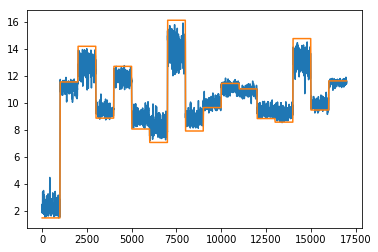

In [540]:
plt.plot(pd.DataFrame(model.predict(xt_mat)).rolling(window=10).mean())
plt.plot(pd.DataFrame(y_mat[:,1]).rolling(window=10).mean())

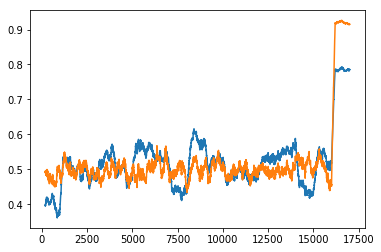

In [530]:
plt.plot(pd.DataFrame(model_pct.predict(xt_mat)).rolling(window=200).mean())
plt.plot(pd.DataFrame(y_mat[:,2]).rolling(window=200).mean())

In [533]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [358]:
for i, j in enumerate(folds.split(x_train, y_train_pct)):
    print(j[0].shape)

(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12693,)
(12694,)
(12694,)
(12694,)
(12694,)
(12694,)


In [330]:
len(scaled_train_X)

17000

In [335]:
model.predict(x_test, num_iteration=model.best_iteration_)

array([0.15786188, 0.32962467, 0.41335944, ..., 0.41108376, 0.78161828,
       0.40864562])

In [360]:
oof = np.zeros(len(scaled_train_X))
predictions_pct = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train_pct)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = x_train[trn_idx,:], x_train[val_idx,:]
    y_tr, y_val = y_train_pct[trn_idx], y_train_pct[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 40000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions_pct += model.predict(x_test, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.142757	valid_1's l1: 0.141542
[2000]	valid_0's l1: 0.105197	valid_1's l1: 0.108963
[3000]	valid_0's l1: 0.0911075	valid_1's l1: 0.0989161
[4000]	valid_0's l1: 0.0834641	valid_1's l1: 0.0948676
[5000]	valid_0's l1: 0.078012	valid_1's l1: 0.0925382
[6000]	valid_0's l1: 0.0736467	valid_1's l1: 0.0909262
[7000]	valid_0's l1: 0.0698389	valid_1's l1: 0.0895066
[8000]	valid_0's l1: 0.0664435	valid_1's l1: 0.0882626
[9000]	valid_0's l1: 0.0633785	valid_1's l1: 0.0871645
[10000]	valid_0's l1: 0.0605879	valid_1's l1: 0.0862527
[11000]	valid_0's l1: 0.0579805	valid_1's l1: 0.0853758
[12000]	valid_0's l1: 0.0555654	valid_1's l1: 0.0845859
[13000]	valid_0's l1: 0.0532969	valid_1's l1: 0.0838673
[14000]	valid_0's l1: 0.0512011	valid_1's l1: 0.0832411
[15000]	valid_0's l1: 0.0492275	valid_1's l1: 0.0826342
[16000]	valid_0's l1: 0.0473864	valid_1's l1: 0.0820842
[17000]	valid_0's l1: 0.0456565	valid_1's l1: 0.

[36000]	valid_0's l1: 0.0255376	valid_1's l1: 0.0779298
[37000]	valid_0's l1: 0.0248952	valid_1's l1: 0.0777773
[38000]	valid_0's l1: 0.0242792	valid_1's l1: 0.0776329
[39000]	valid_0's l1: 0.0236852	valid_1's l1: 0.0774892
[40000]	valid_0's l1: 0.0231145	valid_1's l1: 0.0773562
Did not meet early stopping. Best iteration is:
[40000]	valid_0's l1: 0.0231145	valid_1's l1: 0.0773562
fold 7
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.142661	valid_1's l1: 0.14362
[2000]	valid_0's l1: 0.105204	valid_1's l1: 0.110699
[3000]	valid_0's l1: 0.0911123	valid_1's l1: 0.100153
[4000]	valid_0's l1: 0.0835086	valid_1's l1: 0.0951238
[5000]	valid_0's l1: 0.078101	valid_1's l1: 0.0919066
[6000]	valid_0's l1: 0.0737592	valid_1's l1: 0.0897738
[7000]	valid_0's l1: 0.0699969	valid_1's l1: 0.088121
[8000]	valid_0's l1: 0.066673	valid_1's l1: 0.0867616
[9000]	valid_0's l1: 0.063655	valid_1's l1: 0.0856142
[10000]	valid_0's l1: 0.0608541	valid_1's l1: 0.0845115
[1100

[29000]	valid_0's l1: 0.0308306	valid_1's l1: 0.0784872
[30000]	valid_0's l1: 0.0299573	valid_1's l1: 0.0782542
[31000]	valid_0's l1: 0.0291205	valid_1's l1: 0.0780469
[32000]	valid_0's l1: 0.0283141	valid_1's l1: 0.0778381
[33000]	valid_0's l1: 0.0275493	valid_1's l1: 0.0776481
[34000]	valid_0's l1: 0.0268126	valid_1's l1: 0.0774581
[35000]	valid_0's l1: 0.0261136	valid_1's l1: 0.0772998
[36000]	valid_0's l1: 0.025444	valid_1's l1: 0.0771407
[37000]	valid_0's l1: 0.0247978	valid_1's l1: 0.0769862
[38000]	valid_0's l1: 0.0241781	valid_1's l1: 0.0768391
[39000]	valid_0's l1: 0.0235842	valid_1's l1: 0.0766978
[40000]	valid_0's l1: 0.0230111	valid_1's l1: 0.0765778
Did not meet early stopping. Best iteration is:
[40000]	valid_0's l1: 0.0230111	valid_1's l1: 0.0765778
fold 14
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.1424	valid_1's l1: 0.142252
[2000]	valid_0's l1: 0.105065	valid_1's l1: 0.107835
[3000]	valid_0's l1: 0.0911091	valid_1's l1: 0.097

In [478]:
params = {'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.0025,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 10,
         "bagging_fraction": 0.95,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.2,
         "lambda_l2": 0.2,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [534]:
oof = np.zeros(len(scaled_train_X))
predictions_max = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train, y_train_max)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = x_train[trn_idx,:], x_train[val_idx,:]
    y_tr, y_val = y_train_max[trn_idx], y_train_max[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 40000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions_max += model.predict(x_test, num_iteration=model.best_iteration_) / folds.n_splits

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's l1: 2.18056	valid_1's l1: 2.3032
[2000]	valid_0's l1: 1.96301	valid_1's l1: 2.21731
[3000]	valid_0's l1: 1.78513	valid_1's l1: 2.16143
[4000]	valid_0's l1: 1.63692	valid_1's l1: 2.11734
[5000]	valid_0's l1: 1.50084	valid_1's l1: 2.08039
[6000]	valid_0's l1: 1.38444	valid_1's l1: 2.04913
[7000]	valid_0's l1: 1.28025	valid_1's l1: 2.02552
[8000]	valid_0's l1: 1.1885	valid_1's l1: 2.00443
[9000]	valid_0's l1: 1.1033	valid_1's l1: 1.9864
[10000]	valid_0's l1: 1.02983	valid_1's l1: 1.97159
[11000]	valid_0's l1: 0.958508	valid_1's l1: 1.95629
[12000]	valid_0's l1: 0.895716	valid_1's l1: 1.94441
[13000]	valid_0's l1: 0.835995	valid_1's l1: 1.9334
[14000]	valid_0's l1: 0.781283	valid_1's l1: 1.92421
[15000]	valid_0's l1: 0.726929	valid_1's l1: 1.91473
[16000]	valid_0's l1: 0.678954	valid_1's l1: 1.90635
[17000]	valid_0's l1: 0.637176	valid_1's l1: 1.89882
[18000]	valid_0's l1: 0.596128	valid_1's l1: 1.89254


KeyboardInterrupt: 

In [285]:
params_2 = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.00025,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [286]:
model_2 = lgb.LGBMRegressor(**params_2, n_estimators = 20000, n_jobs = -1)
model_2.fit(x_train, y_train_pct, 
                eval_set=[(x_train, y_train_pct), (x_test, y_test_pct)], eval_metric='mae',
                verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.215726	valid_1's l1: 0.216899
[2000]	valid_0's l1: 0.183649	valid_1's l1: 0.186025
[3000]	valid_0's l1: 0.159724	valid_1's l1: 0.163214
[4000]	valid_0's l1: 0.141764	valid_1's l1: 0.146154
[5000]	valid_0's l1: 0.128193	valid_1's l1: 0.133404
[6000]	valid_0's l1: 0.11798	valid_1's l1: 0.123957
[7000]	valid_0's l1: 0.110251	valid_1's l1: 0.116986
[8000]	valid_0's l1: 0.104319	valid_1's l1: 0.111813
[9000]	valid_0's l1: 0.0996642	valid_1's l1: 0.10795
[10000]	valid_0's l1: 0.0959605	valid_1's l1: 0.105005
[11000]	valid_0's l1: 0.0928955	valid_1's l1: 0.102685
[12000]	valid_0's l1: 0.0903197	valid_1's l1: 0.100835
[13000]	valid_0's l1: 0.08809	valid_1's l1: 0.0993013
[14000]	valid_0's l1: 0.0861205	valid_1's l1: 0.098018
[15000]	valid_0's l1: 0.0843471	valid_1's l1: 0.0969145
[16000]	valid_0's l1: 0.0827276	valid_1's l1: 0.0959519
[17000]	valid_0's l1: 0.0812118	valid_1's l1: 0.095071
[18000]	valid_0's l1

LGBMRegressor(bagging_fraction=0.91, bagging_freq=1, bagging_seed=42,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.91,
       importance_type='split', lambda_l1=0.1, learning_rate=0.00025,
       max_depth=-1, metric='mae', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
       n_estimators=20000, n_jobs=-1, nthread=-1, num_leaves=51,
       objective='regression', random_state=42, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [538]:
params = {'num_leaves': 20,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.5,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [539]:
model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
model.fit(x_train, y_train_max, 
                eval_set=[(x_train, y_train_max), (x_test, y_test_max)], eval_metric='mae',
                verbose=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 1.78016	valid_1's l1: 2.08947
[2000]	valid_0's l1: 1.40445	valid_1's l1: 1.9475
[3000]	valid_0's l1: 1.1307	valid_1's l1: 1.86227
[4000]	valid_0's l1: 0.925459	valid_1's l1: 1.80541
[5000]	valid_0's l1: 0.76908	valid_1's l1: 1.76904
[6000]	valid_0's l1: 0.643012	valid_1's l1: 1.74157
[7000]	valid_0's l1: 0.541751	valid_1's l1: 1.72063
[8000]	valid_0's l1: 0.457978	valid_1's l1: 1.70398
[9000]	valid_0's l1: 0.390283	valid_1's l1: 1.69144
[10000]	valid_0's l1: 0.332696	valid_1's l1: 1.68127
[11000]	valid_0's l1: 0.284786	valid_1's l1: 1.67323
[12000]	valid_0's l1: 0.244612	valid_1's l1: 1.66671
[13000]	valid_0's l1: 0.210763	valid_1's l1: 1.66137
[14000]	valid_0's l1: 0.182141	valid_1's l1: 1.65696
[15000]	valid_0's l1: 0.158025	valid_1's l1: 1.65365
[16000]	valid_0's l1: 0.137645	valid_1's l1: 1.65099
[17000]	valid_0's l1: 0.120044	valid_1's l1: 1.64851
[18000]	valid_0's l1: 0.104976	valid_1's l1: 1.6465

LGBMRegressor(bagging_fraction=0.91, bagging_freq=1, bagging_seed=42,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.91,
       importance_type='split', lambda_l1=0.5, learning_rate=0.01,
       max_depth=5, metric='mae', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
       n_estimators=20000, n_jobs=-1, nthread=-1, num_leaves=20,
       objective='regression', random_state=42, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [ ]:
model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
model.fit(x_train, y_train_ttq, 
                eval_set=[(x_train, y_train_ttq), (x_test, y_test_ttq)], eval_metric='mae',
                verbose=1000, early_stopping_rounds=200)

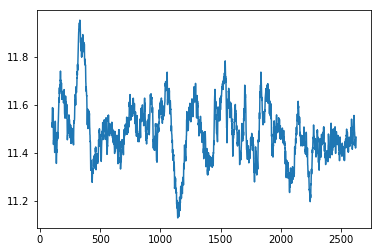

In [413]:
plt.plot(pd.DataFrame(model.predict(xsub_mat)).rolling(window=100).mean())

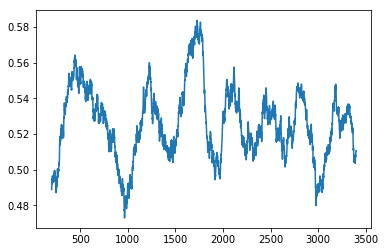

In [482]:
plt.plot(pd.DataFrame(predictions_pct).rolling(window=200).mean())

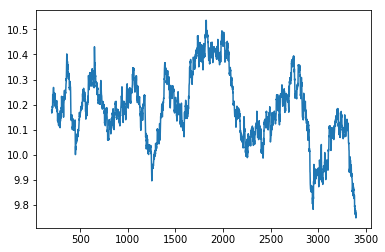

In [483]:
plt.plot(pd.DataFrame(predictions_max).rolling(window=200).mean())

In [486]:
a = predictions_pct*predictions_max

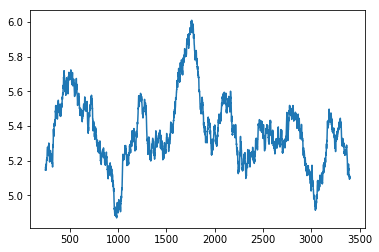

In [487]:
plt.plot(pd.DataFrame(a).rolling(window=250).mean())

In [291]:
b = model.predict(x_test)*model_2.predict(x_test)

In [296]:
np.mean(np.abs(b-y_test_ttq))

1.4004421755493077

In [251]:
files = os.listdir("../input/test")
sub_mat = np.zeros([len(files), 150000])
seq = []
for i, file in enumerate(files):
    if i%100 == 0:
        print(i)
    sub = pd.read_csv('../input/test/' + file)
    sub_mat[i, :] = sub.acoustic_data.values
    seq.append(file[:-4])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [252]:
sub_X = pd.DataFrame(index=range(len(files)), dtype=np.float64)
for seg_id in tqdm_notebook(range(len(files))):
#     seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    seg = pd.DataFrame({'signal': sub_mat[seg_id, :]})
    create_features(seg_id, seg, sub_X)

In [255]:
x_sub_mat = sub_X.values

In [256]:
# np.save("../input/x_sub_mat.npy", x_sub_mat)

In [257]:
scaled_sub_X = pd.DataFrame(scaler.transform(sub_X), columns=sub_X.columns)
xsub_mat = scaled_sub_X.values

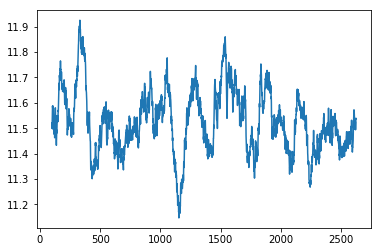

In [278]:
plt.plot(pd.DataFrame(model.predict(xsub_mat)).rolling(window=100).mean())

In [298]:
sub = model.predict(xsub_mat)*model_2.predict(xsub_mat)

In [299]:
sub

array([3.757185  , 5.23612801, 4.93591588, ..., 3.48128621, 1.92233838,
       8.02778216])

In [302]:
sub_base = pd.read_csv('../output/submission_1.csv')

In [303]:
sub_base.head()

,seg_id,time_to_failure
0,seg_00030f,4.734817
1,seg_0012b5,6.204652
2,seg_00184e,6.770234
3,seg_003339,8.717044
4,seg_0042cc,7.732416


In [496]:
sub_base['time_to_failure'] = pd.Series(predictions_max*predictions_pct)

In [497]:
sub_base.to_csv('../output/submission_5.csv', index=False)

In [498]:
pd.read_csv('../output/submission_5.csv')['time_to_failure']

0        1.948527
1        2.469654
2        4.626131
3        5.030180
4        6.072856
5        3.096531
6        5.786799
7        3.608239
8        8.748874
9        8.078450
10       0.317039
11       1.344975
12       3.549116
13       6.411773
14       3.921419
15       6.920947
16       2.237546
17       1.045758
18       2.471316
19       5.522474
20       3.544781
21       8.222165
22       8.446309
23      10.111752
24       2.892405
25       5.650665
26       8.152197
27       1.544105
28       8.601407
29      11.063358
          ...    
2594     3.438192
2595     8.200475
2596     8.135162
2597     5.545178
2598     3.731869
2599     7.372528
2600    10.141803
2601     7.074621
2602     1.912858
2603    10.513795
2604     5.631226
2605     3.361961
2606     2.220575
2607     6.722504
2608     3.413641
2609     3.217516
2610     4.082883
2611     4.624171
2612     3.874101
2613     5.241698
2614     1.781255
2615     2.674016
2616     9.310068
2617     9.269447
2618     2

In [500]:
np.mean(np.abs(pd.read_csv('../output/submission_4.csv')['time_to_failure'] - pd.read_csv('../output/submission_5.csv')['time_to_failure']))

3.0798221697197112

In [ ]:
oof = np.zeros(len(scaled_train_X))
# predictions = np.zeros(len(scaled_test_X))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(scaled_test_X, num_iteration=model.best_iteration_) / folds.n_splits

In [208]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

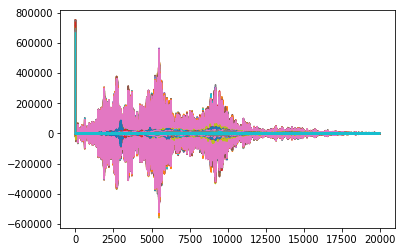

In [543]:
for i in range(100):
    plt.plot(np.fft.fft(x_mat[i,:])[:20000])

In [40]:
%%time
xlog=np.zeros(shape=x_mat.shape)
for i in range(x_mat.shape[0]):
    xlog[i, :] = np.log(np.abs(np.fft.fft(x_mat[i,:]).real))

Wall time: 3min 9s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
dense_186 (Dense)            (None, 2)                 2002      
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 3         
Total params: 2,005
Trainable params: 2,005
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 2000 samples
Epoch 1/10000
20000/20000 [==============================] - 4s 179us/step - loss: 17.8050 - mean_absolute_error: 3.4140 - mean_squared_error: 17.8050 - val_loss: 16.9013 - val_mean_absolute_error: 3.4324 - val_mean_squared_error: 16.9013
Epoch 2/10000
20000/20000 [==============================] - 0s 13us/step - loss: 14.0238 - mean_absolute_error

20000/20000 [==============================] - 0s 13us/step - loss: 13.1649 - mean_absolute_error: 2.9865 - mean_squared_error: 13.1649 - val_loss: 15.9441 - val_mean_absolute_error: 3.3324 - val_mean_squared_error: 15.9441
Epoch 33/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.1583 - mean_absolute_error: 2.9865 - mean_squared_error: 13.1583 - val_loss: 15.9271 - val_mean_absolute_error: 3.3280 - val_mean_squared_error: 15.9271
Epoch 34/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.1099 - mean_absolute_error: 2.9809 - mean_squared_error: 13.1099 - val_loss: 16.0204 - val_mean_absolute_error: 3.3165 - val_mean_squared_error: 16.0204
Epoch 35/10000
20000/20000 [==============================] - 0s 13us/step - loss: 13.0798 - mean_absolute_error: 2.9755 - mean_squared_error: 13.0798 - val_loss: 15.9466 - val_mean_absolute_error: 3.3156 - val_mean_squared_error: 15.9466
Epoch 36/10000
20000/20000 [==============================]

20000/20000 [==============================] - 0s 13us/step - loss: 11.6912 - mean_absolute_error: 2.7886 - mean_squared_error: 11.6912 - val_loss: 14.4421 - val_mean_absolute_error: 3.1427 - val_mean_squared_error: 14.4421
Epoch 101/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6673 - mean_absolute_error: 2.7843 - mean_squared_error: 11.6673 - val_loss: 14.4192 - val_mean_absolute_error: 3.1407 - val_mean_squared_error: 14.4192
Epoch 102/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6494 - mean_absolute_error: 2.7829 - mean_squared_error: 11.6494 - val_loss: 14.5214 - val_mean_absolute_error: 3.1317 - val_mean_squared_error: 14.5214
Epoch 103/10000
20000/20000 [==============================] - 0s 13us/step - loss: 11.6411 - mean_absolute_error: 2.7797 - mean_squared_error: 11.6411 - val_loss: 14.4795 - val_mean_absolute_error: 3.1302 - val_mean_squared_error: 14.4795
Epoch 104/10000
20000/20000 [===========================

20000/20000 [==============================] - 0s 13us/step - loss: 10.6944 - mean_absolute_error: 2.6406 - mean_squared_error: 10.6944 - val_loss: 13.3741 - val_mean_absolute_error: 3.0000 - val_mean_squared_error: 13.3741
Epoch 169/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6728 - mean_absolute_error: 2.6362 - mean_squared_error: 10.6728 - val_loss: 13.3302 - val_mean_absolute_error: 3.0010 - val_mean_squared_error: 13.3302
Epoch 170/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6586 - mean_absolute_error: 2.6343 - mean_squared_error: 10.6586 - val_loss: 13.2852 - val_mean_absolute_error: 3.0031 - val_mean_squared_error: 13.2852
Epoch 171/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.6556 - mean_absolute_error: 2.6357 - mean_squared_error: 10.6556 - val_loss: 13.4711 - val_mean_absolute_error: 2.9885 - val_mean_squared_error: 13.4711
Epoch 172/10000
20000/20000 [===========================

20000/20000 [==============================] - 0s 13us/step - loss: 10.0127 - mean_absolute_error: 2.5328 - mean_squared_error: 10.0127 - val_loss: 12.5637 - val_mean_absolute_error: 2.9000 - val_mean_squared_error: 12.5637
Epoch 237/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.0087 - mean_absolute_error: 2.5319 - mean_squared_error: 10.0087 - val_loss: 12.5930 - val_mean_absolute_error: 2.8952 - val_mean_squared_error: 12.5930
Epoch 238/10000
20000/20000 [==============================] - 0s 13us/step - loss: 10.0104 - mean_absolute_error: 2.5307 - mean_squared_error: 10.0104 - val_loss: 12.4530 - val_mean_absolute_error: 2.9208 - val_mean_squared_error: 12.4530
Epoch 239/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.9951 - mean_absolute_error: 2.5314 - mean_squared_error: 9.9951 - val_loss: 12.5065 - val_mean_absolute_error: 2.9004 - val_mean_squared_error: 12.5065
Epoch 240/10000
20000/20000 [=============================

20000/20000 [==============================] - 0s 13us/step - loss: 9.5670 - mean_absolute_error: 2.4588 - mean_squared_error: 9.5670 - val_loss: 12.0212 - val_mean_absolute_error: 2.8300 - val_mean_squared_error: 12.0212
Epoch 305/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5622 - mean_absolute_error: 2.4609 - mean_squared_error: 9.5622 - val_loss: 12.1352 - val_mean_absolute_error: 2.8194 - val_mean_squared_error: 12.1352
Epoch 306/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5559 - mean_absolute_error: 2.4570 - mean_squared_error: 9.5559 - val_loss: 12.0214 - val_mean_absolute_error: 2.8265 - val_mean_squared_error: 12.0214
Epoch 307/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.5615 - mean_absolute_error: 2.4597 - mean_squared_error: 9.5615 - val_loss: 12.0992 - val_mean_absolute_error: 2.8187 - val_mean_squared_error: 12.0992
Epoch 308/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 9.2867 - mean_absolute_error: 2.4125 - mean_squared_error: 9.2867 - val_loss: 11.8381 - val_mean_absolute_error: 2.7711 - val_mean_squared_error: 11.8381
Epoch 373/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2898 - mean_absolute_error: 2.4119 - mean_squared_error: 9.2898 - val_loss: 11.7829 - val_mean_absolute_error: 2.7716 - val_mean_squared_error: 11.7829
Epoch 374/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2663 - mean_absolute_error: 2.4067 - mean_squared_error: 9.2663 - val_loss: 11.6159 - val_mean_absolute_error: 2.7886 - val_mean_squared_error: 11.6159
Epoch 375/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.2892 - mean_absolute_error: 2.4154 - mean_squared_error: 9.2892 - val_loss: 11.7594 - val_mean_absolute_error: 2.7711 - val_mean_squared_error: 11.7594
Epoch 376/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 9.0918 - mean_absolute_error: 2.3774 - mean_squared_error: 9.0918 - val_loss: 11.4041 - val_mean_absolute_error: 2.7535 - val_mean_squared_error: 11.4041
Epoch 441/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.1035 - mean_absolute_error: 2.3822 - mean_squared_error: 9.1035 - val_loss: 11.5667 - val_mean_absolute_error: 2.7401 - val_mean_squared_error: 11.5667
Epoch 442/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.0786 - mean_absolute_error: 2.3760 - mean_squared_error: 9.0786 - val_loss: 11.5791 - val_mean_absolute_error: 2.7393 - val_mean_squared_error: 11.5791
Epoch 443/10000
20000/20000 [==============================] - 0s 13us/step - loss: 9.0794 - mean_absolute_error: 2.3750 - mean_squared_error: 9.0794 - val_loss: 11.4773 - val_mean_absolute_error: 2.7431 - val_mean_squared_error: 11.4773
Epoch 444/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.9647 - mean_absolute_error: 2.3527 - mean_squared_error: 8.9647 - val_loss: 11.2300 - val_mean_absolute_error: 2.7350 - val_mean_squared_error: 11.2300
Epoch 509/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9622 - mean_absolute_error: 2.3565 - mean_squared_error: 8.9622 - val_loss: 11.3079 - val_mean_absolute_error: 2.7236 - val_mean_squared_error: 11.3079
Epoch 510/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9522 - mean_absolute_error: 2.3536 - mean_squared_error: 8.9522 - val_loss: 11.2877 - val_mean_absolute_error: 2.7249 - val_mean_squared_error: 11.2877
Epoch 511/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.9749 - mean_absolute_error: 2.3571 - mean_squared_error: 8.9749 - val_loss: 11.3696 - val_mean_absolute_error: 2.7195 - val_mean_squared_error: 11.3696
Epoch 512/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.8965 - mean_absolute_error: 2.3449 - mean_squared_error: 8.8965 - val_loss: 11.2985 - val_mean_absolute_error: 2.7043 - val_mean_squared_error: 11.2985
Epoch 577/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8697 - mean_absolute_error: 2.3364 - mean_squared_error: 8.8697 - val_loss: 11.1442 - val_mean_absolute_error: 2.7149 - val_mean_squared_error: 11.1442
Epoch 578/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8761 - mean_absolute_error: 2.3402 - mean_squared_error: 8.8761 - val_loss: 11.1741 - val_mean_absolute_error: 2.7108 - val_mean_squared_error: 11.1741
Epoch 579/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8761 - mean_absolute_error: 2.3387 - mean_squared_error: 8.8761 - val_loss: 11.1633 - val_mean_absolute_error: 2.7116 - val_mean_squared_error: 11.1633
Epoch 580/10000
20000/20000 [==============================] - 0

20000/20000 [==============================] - 0s 13us/step - loss: 8.8409 - mean_absolute_error: 2.3350 - mean_squared_error: 8.8409 - val_loss: 11.3509 - val_mean_absolute_error: 2.6937 - val_mean_squared_error: 11.3509
Epoch 645/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8290 - mean_absolute_error: 2.3289 - mean_squared_error: 8.8290 - val_loss: 11.2256 - val_mean_absolute_error: 2.6941 - val_mean_squared_error: 11.2256
Epoch 646/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8176 - mean_absolute_error: 2.3271 - mean_squared_error: 8.8176 - val_loss: 11.0453 - val_mean_absolute_error: 2.7079 - val_mean_squared_error: 11.0453
Epoch 647/10000
20000/20000 [==============================] - 0s 13us/step - loss: 8.8103 - mean_absolute_error: 2.3285 - mean_squared_error: 8.8103 - val_loss: 11.0807 - val_mean_absolute_error: 2.7019 - val_mean_squared_error: 11.0807
Epoch 648/10000
20000/20000 [==============================] - 0

KeyboardInterrupt: 

In [189]:
import tensorflow
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, Input, Bidirectional

inputs = Input(shape=x_train.shape[1:])
X = Bidirectional(LSTM(units=8, return_sequences=False))(inputs)
# X = Flatten(X)
predictions = Dense(1)(X)

model = Model(inputs=inputs, outputs=predictions)
print(model.summary())
model.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
model.fit(x_train, y_train, epochs=100, batch_size=250, verbose=1, validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 800, 5)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 16)                896       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 17        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________
None
Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 284s 14ms/step - loss: 14.6835 - mean_absolute_error: 3.1077 - mean_squared_error: 14.6835 - val_loss: 15.8525 - val_mean_absolute_error: 3.3142 - val_mean_squared_error: 15.8525
Epoch 2/100
20000/20000 [==============================] - 280s 14ms/step - loss: 13.0936 - mean_absolute_error: 2.9

KeyboardInterrupt: 

In [322]:
import tensorflow
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout

#create model
model = Sequential()

#add model layers
model.add(Conv2D(16, kernel_size=(1,5), activation='relu', input_shape=(200,5,1)))
model.add(Flatten())
model.add(Conv1D(4, kernel_size=3, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(x_val, y_val))

ValueError: Input 0 is incompatible with layer conv1d_41: expected ndim=3, found ndim=2

In [326]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Activation, CuDNNLSTM
from keras.optimizers import SGD
# create and fit the LSTM network
mod = Sequential()
mod.add(Bidirectional(CuDNNLSTM(units=24, return_sequences=True, input_shape=x_train.shape[1:])))
mod.add(CuDNNLSTM(units=2, return_sequences=False))
mod.add(Dense(1, activation='relu'))
mod.compile(loss='mean_squared_error', optimizer=SGD(), metrics=['mae','mean_squared_error'])
mod.fit(x_train, y_train, epochs=100, batch_size=500, verbose=1, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 2000 samples
Epoch 1/100
20000/20000 [==============================] - 13s 632us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 2/100
20000/20000 [==============================] - 8s 404us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 3/100
20000/20000 [==============================] - 8s 401us/step - loss: 44.6518 - mean_absolute_error: 5.6182 - mean_squared_error: 44.6518 - val_loss: 51.4370 - val_mean_absolute_error: 5.9779 - val_mean_squared_error: 51.4370
Epoch 4/100
18500/20000 [==========================>...] - ETA: 0s - loss: 44.6194 - mean_absolute_error: 5.6105 - mean_squared_error: 44.6194

KeyboardInterrupt: 

In [35]:
model.predict(x)

array([[4.097053 ],
       [2.7425199],
       [2.9276323],
       ...,
       [3.5980787],
       [4.600548 ],
       [8.837812 ]], dtype=float32)

In [217]:
model.predict(x_train)

array([[4.9028196],
       [3.3967416],
       [3.6990693],
       ...,
       [5.9858127],
       [2.9790916],
       [7.1291265]], dtype=float32)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [220]:
test_mat

array([[ 4.,  0., -2., ...,  6.,  9.,  8.],
       [ 5.,  8.,  8., ...,  2.,  1.,  3.],
       [ 8.,  2.,  3., ..., -1.,  2.,  5.],
       ...,
       [ 3.,  0.,  0., ...,  3.,  2.,  5.],
       [ 3., -3.,  3., ...,  1.,  1.,  3.],
       [ 6.,  5.,  5., ...,  2.,  1.,  3.]])

In [221]:
test_mat.shape

(2624, 150000)

In [222]:
test_mat[1, :].shape

(150000,)

In [79]:
x_test = np.zeros([len(files), n_obs, 4])
for i in range(len(files)):
    if i%500==0:
        print(i)
    for j in range(n_obs):
        x_test[i,j,0] = np.max(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,1] = np.min(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,2] = np.mean(test_mat[i, j*step_size:(j+1)*step_size])
        x_test[i,j,3] = np.std(test_mat[i, j*step_size:(j+1)*step_size])

0
500
1000
1500
2000
2500


In [224]:
x_test = np.zeros([len(files), int(size/step_size),5])
x_test[:, :, 0] = np.max(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 1] = np.min(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 2] = np.mean(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 3] = np.std(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)
x_test[:, :, 4] = scipy.stats.kurtosis(test_mat.reshape([2624,int(size/step_size),step_size]),axis=2)

In [81]:
x_test.shape

(2624, 100, 4)

In [225]:
preds = model.predict(x_test)[:,0]

In [226]:
preds

array([4.3751645, 6.6565156, 6.468862 , ..., 3.238063 , 2.5696244,
       9.150722 ], dtype=float32)

In [227]:
submission = pd.DataFrame({'seg_id': seq, 'time_to_failure': preds})

In [228]:
submission.to_csv('../output/submission_3.csv', index=False)